In [1]:
%cd  drive/My\ Drive/Programs/Deep\ Learning/Tweeter Sentiment/Predicting text/Bidirectional+Attention

/content/drive/My Drive/Programs/Deep Learning/Tweeter Sentiment/Predicting text/Bidirectional+Attention


In [2]:
encoder_max_length = 42
decoder_max_length = 43

In [3]:
import pickle

with open('../Lib/encoder_vocab.pkl', 'rb') as f:
  encoder_vocab = pickle.load(f)

with open('../Lib/decoder_vocab.pkl', 'rb') as f:
  decoder_vocab = pickle.load(f)

with open('../Lib/encoder_inputs.pkl', 'rb') as f:
  encoder_input = pickle.load(f)

with open('../Lib/decoder_inputs.pkl', 'rb') as f:
  decoder_input = pickle.load(f)


In [4]:
import numpy as np
X_train_encoder = np.zeros(shape=(len(encoder_input), encoder_max_length, len(encoder_vocab)))
X_train_decoder = np.zeros(shape=(len(encoder_input), decoder_max_length, len(decoder_vocab)))

In [5]:
y_train = np.zeros(shape=(len(encoder_input), decoder_max_length, len(decoder_vocab)))

In [6]:
for i, (input_text, target_text) in enumerate(zip(encoder_input, decoder_input)):
    for enc_t, char in enumerate(input_text):
    #     X_train_encoder[i, encoder_max_length-1-t, encoder_vocab.index(char)] = 1.
    # X_train_encoder[i, 0:encoder_max_length-t, encoder_vocab.index(' ')] = 1.
        X_train_encoder[i, enc_t, encoder_vocab.index(char)] = 1.
    if enc_t+1< encoder_max_length:
      X_train_encoder[i, enc_t+1:, encoder_vocab.index(' ')] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        X_train_decoder[i, t, decoder_vocab.index(char)] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            y_train[i, t - 1, decoder_vocab.index(char)] = 1.
    X_train_decoder[i, t + 1:, decoder_vocab.index(' ')] = 1.
    y_train[i, t:, decoder_vocab.index(' ')] = 1.

In [7]:
#building model
from tensorflow.python.keras.layers import Input, GRU, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.python.keras.models import Model
from tensorflow.keras.optimizers import Adam
from attention import AttentionLayer
def define_nmt(hidden_size, enc_inputsize, dec_outsize):
    """ Defining a NMT model """

    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, enc_inputsize), name='encoder_inputs')
    decoder_inputs = Input(shape=(None, dec_outsize), name='decoder_inputs')

    # Encoder GRU
    encoder_gru = Bidirectional(GRU(hidden_size, return_sequences=True, return_state=True, recurrent_dropout=0.3, name='encoder_gru'))
    encoder_out, forward_encoder_state, backward_encoder_state = encoder_gru(encoder_inputs)
    encoder_state = Concatenate()([forward_encoder_state, backward_encoder_state])
    # Set up the decoder GRU, using `encoder_states` as initial state.
    decoder_gru = GRU(hidden_size*2, return_sequences=True, return_state=True, recurrent_dropout=0.3, name='decoder_gru')
    decoder_out, decoder_state = decoder_gru(decoder_inputs, initial_state=encoder_state)

    # Attention layer
    attn_layer = AttentionLayer(name='attention_layer')
    attn_out, attn_states = attn_layer([encoder_out, decoder_out])

    # Concat attention input and decoder GRU output
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_out, attn_out])

    # Dense layer
    dense = Dense(dec_outsize, activation='softmax', name='softmax_layer')
    dense_time = TimeDistributed(dense, name='time_distributed_layer')
    decoder_pred = dense_time(decoder_concat_input)

    # Full model
    full_model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_pred)
    full_model.compile(optimizer='adam', loss='categorical_crossentropy')

    print(full_model.summary())

    "Inference Model"
    """ Encoder (Inference) model """
    encoder_inf_inputs = Input(batch_shape=(None, None,enc_inputsize), name='encoder_inf_inputs')
    encoder_inf_out = encoder_gru(encoder_inf_inputs)
    encoder_model = Model(inputs=encoder_inf_inputs, outputs=encoder_inf_out)
    print(len(encoder_inf_out))
    print(encoder_inf_out[0].shape)
    print('Encoder input-output')
    print(encoder_model.input_shape)
    print(encoder_model.output_shape)
    """ Decoder (Inference) model """
    decoder_inf_inputs = Input(batch_shape=(None, None, dec_outsize), name='decoder_word_inputs')
    encoder_inf_states = Input(batch_shape=(None, None, hidden_size*2), name='encoder_inf_states')
    decoder_init_state = Input(batch_shape=(None, hidden_size*2), name='decoder_init')

    decoder_inf_out, decoder_inf_state = decoder_gru(decoder_inf_inputs, initial_state=decoder_init_state)
    attn_inf_out, attn_inf_states = attn_layer([encoder_inf_states, decoder_inf_out])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_inf_out, attn_inf_out])
    decoder_inf_pred = TimeDistributed(dense)(decoder_inf_concat)
    decoder_model = Model(inputs=[encoder_inf_states, decoder_init_state, decoder_inf_inputs],
                          outputs=[decoder_inf_pred, attn_inf_states, decoder_inf_state])
    print('Decoder input-output')
    print(decoder_model.input_shape)
    print(decoder_model.output_shape)
    return full_model, encoder_model, decoder_model
HIDDEN_DIM = 10
model, encoder_model, decoder_model = define_nmt(HIDDEN_DIM, len(encoder_vocab), len(decoder_vocab))
model.compile(optimizer=Adam(0.0075), loss='categorical_crossentropy', metrics=['accuracy'])

encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
ci> (None, 20)
ci> (None, 20)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, None, 18)]   0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, None, 20), ( 1800        encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 20)]   0                                            
________________________________________________________________________

In [8]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import EarlyStopping
filepath = 'Data/weights-improvement'+str(HIDDEN_DIM)+'-{epoch:02d}-{loss:04f}-{accuracy:04f}.hdf5'
callbacks_list = [
             EarlyStopping(monitor='val_loss', patience=0),
            #  ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
]
history = model.fit([X_train_encoder, X_train_decoder], y_train,
          batch_size=1024,
          epochs=120,
          callbacks=callbacks_list,
          validation_split=0.2, verbose=1, shuffle=True)



#load the network weights
# filename = 'Data/weights-improvement220-200-0.006247-0.998085.hdf5'
# model.load_weights(filename)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/120
encoder_out_seq> (None, 42, 20)
decoder_out_seq> (None, 43, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
ci> (None, 20)
ci> (None, 20)
encoder_out_seq> (None, 42, 20)
decoder_out_seq> (None, 43, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
ci> (None, 20)
ci> (None, 20)
22/22 [==============================] - ETA: 0s - loss: 1.4585 - accuracy: 0.7184encoder_out_seq> (None, 42, 20)
decoder_out_seq> (None, 43, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
ci> (None, 20)
ci> (None, 20)
22/22 [==============================] - 19s 874ms/step - loss: 1.4585 - accuracy: 0.7184 - val_loss: 0.7216 - val_accuracy: 0.7872
Epoch 2/120
22/22 [==============================] - 18s 823ms/step - loss: 0.6621 - accuracy: 0.8032 - val_loss: 0.5958 - val_accuracy: 0.8219
Epoch 

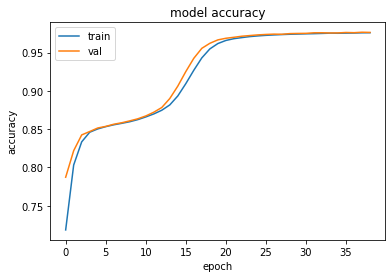

In [9]:
  import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
model.save('bidirectional_attention.hd5')

encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
ci> (None, 20)
ci> (None, 20)
encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
ci> (None, 20)
ci> (None, 20)
encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
ci> (None, 20)
ci> (None, 20)
encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (None, None)
ci> (None, 20)
ci> (None, 20)
encoder_out_seq> (None, None, 20)
decoder_out_seq> (None, None, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, None, 20)
ei> (Non

In [11]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    enc_outs = encoder_model.predict(input_seq)
    # print(len(enc_outs))
    # print(enc_outs[0].shape)
    # print(enc_outs[1].shape)
    # print(enc_outs[2].shape)
    states_value = Concatenate()([enc_outs[1], enc_outs[2]])
    
    print(states_value.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(decoder_vocab)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, decoder_vocab.index('BOS')] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, attention, states_value = decoder_model.predict([enc_outs[0], states_value, target_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = decoder_vocab[sampled_token_index]
        decoded_sentence.append(sampled_char)
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'EOS' or
           len(decoded_sentence) > decoder_max_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(decoder_vocab)))
        target_seq[0, 0, sampled_token_index] = 1.

    return decoded_sentence

In [12]:
for seq_index in range(30):
   
    input_seq = X_train_encoder[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', encoder_input[seq_index])
    print('Decoded sentence:', decoded_sentence)
    print('Actual sentence:', decoder_input[seq_index])

(1, 20)
encoder_out_seq> (None, 42, 20)
decoder_out_seq> (None, 1, 20)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
Ua.h> (None, 1, 20)
Ws+Uh> (None, 42, 20)
ei> (None, 42)
ci> (None, 20)
ci> (None, 20)
-
Input sentence: ['PRON', 'VERB', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB']
Decoded sentence: ['PRON', 'VERB', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB']
Actual sentence: ['BOS', 'PRON', 'VERB', 'AUX', 'VERB', 'SCONJ', 'PRON', 'AUX', 'VERB', 'EOS']
(1, 20)
-
Input sentence: ['PROPN', 'PROPN', 'ADJ', 'PRON', 'VERB', 'VERB', 'PRON', 'ADV', 'ADP', 'PROPN', 'PROPN']
Decoded sentence: ['PROPN', 'PROPN', 'ADJ', 'PRON', 'VERB', 'VERB', 'PRON', 'ADV', 'ADP', 'PROPN', 'PROPN', 'EOS']
Actual 

In [13]:
!pip install spacy[cuda100]
!sudo apt-get install python-enchant
!sudo pip install pyenchant
!pip install pyspellchecker
!pip install wordninja

     |████████████████████████████████| 341.6MB 46kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko python-gobject python-gtk2
  python-wxgtk3.0
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
  python-enchant
0 upgraded, 11 newly installed, 0 to remove and 35 not upgraded.
Need to get 1,354 kB of archives.
After this operation, 5,584 kB of 

In [14]:
import spacy
# spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm')

In [31]:
import enchant
import re
from spellchecker import SpellChecker
import wordninja
from tqdm import tqdm
d = enchant.Dict("en")
spell = SpellChecker(distance=3)
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    text = re.sub(r"`", "\'", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", " will not", text)
    text = re.sub(r"can't", " cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", " about", text)
    text = re.sub(r"'til", " until", text)
    text = re.sub(r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'url', text)
    text = re.sub(r'[^a-z0-9.,\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    new_text = []
    for word in nlp(text.strip()):
        if not d.check(word.text):
            new_text+=[word.text for split_word in wordninja.split(word.text)]
#             new_text.append(spell.correction(word))
        else:
            new_text.append(word.text)
    return ' '.join(new_text)

In [30]:
def decode_sentence(input_text):
    # Encode the input as state vectors.
    input_seq = np.zeros(shape=(1, encoder_max_length, len(encoder_vocab)))
    for t, char in enumerate(input_text):
        input_seq[0, t, encoder_vocab.index(char)] = 1.
    if t+1< encoder_max_length:
      input_seq[0, t+1:, encoder_vocab.index(' ')] = 1.
    enc_outs = encoder_model.predict(input_seq)
    # print(len(enc_outs))
    # print(enc_outs[0].shape)
    # print(enc_outs[1].shape)
    # print(enc_outs[2].shape)
    states_value = Concatenate()([enc_outs[1], enc_outs[2]])
    
    print(states_value.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, len(decoder_vocab)))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, decoder_vocab.index('BOS')] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []
    while not stop_condition:
        output_tokens, attention, states_value = decoder_model.predict([enc_outs[0], states_value, target_seq])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = decoder_vocab[sampled_token_index]
        if sampled_char != 'EOS':
          decoded_sentence.append("(<"+sampled_char+">)")
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'EOS' or
           len(decoded_sentence) > decoder_max_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, len(decoder_vocab)))
        target_seq[0, 0, sampled_token_index] = 1.

    return ''.join(decoded_sentence)

In [42]:
def phrase_extractor(sentence):
    sentence = clean_text(sentence)
    doc = nlp(sentence)
    list_pos = [token.pos_ for token in doc]
    list_text = [token.text for token in doc]
    start = 0
    end = len(list_pos)
    posString = ""
    rule = decode_sentence(list_pos)
    for index, w in enumerate(list_pos):
        posString += "<" + w + ">"

    lst = []
    rules = rule.split('(<PUNCT>)')
    for rule in rules:
      for m in re.finditer(rule, posString):
          numTokensInGroup = m.group().count('<')
          if numTokensInGroup >= 1:
              numTokensBeforeGroup = posString[:m.start()].count('<')

              phrase = list_text[numTokensBeforeGroup:
                                      numTokensBeforeGroup+numTokensInGroup]
              lst.append(' '.join(phrase))
    return lst

In [43]:
phrase_extractor('do i look happy')

(1, 20)


['do i look happy']

In [44]:
phrase_extractor('i had purchased this product a few days ago and upon setting up the same in my car no odur could be sensed')

(1, 20)


['few', 'same']

In [45]:
phrase_extractor('upon setting up the same in my car no odur could be sensed')

(1, 20)


['upon setting up the same in my car no odur odur could be sensed']

In [46]:
phrase_extractor("i had purchased this product a few days ago")

(1, 20)


['i had purchased this product a few days ago']

In [47]:
phrase_extractor("the product was not in good condition. no fragrance coming at all. instead of gel the same had become liquid. seller should be given negative rating for the same. worst seller.")

(1, 20)


['the product was not in good']

In [48]:
phrase_extractor("no fragrance coming at all. instead of gel the same had become liquid. seller should be given negative rating for the same. worst seller.")

(1, 20)


['no fragrance coming at all',
 'instead of gel the same had become liquid',
 'seller should be given negative rating for the same',
 'negative rating',
 'worst seller']

In [50]:
phrase_extractor("smell is very poor and mild.... doubtful of having the same is original or duplicate...")

(1, 20)


['poor', 'mild', 'doubtful', 'same', 'original', 'duplicate']

In [52]:
phrase_extractor("i would not receommend this.it is almost 370 rs cost but not worth it. plastic quality is very poor.")

(1, 20)


['i would not receommend receommend receommend receommend url is almost 370 rs cost but not worth it',
 'plastic quality is very poor']

In [54]:
phrase_extractor("if you open it you can get smell only if your nose touches the device. but not understood why that much cost. godrej should answer this. also refill not avilable.")

(1, 20)


['if you open it you can get smell only if your nose touches the device',
 'but not understood why that much cost',
 'godrej godrej should answer this',
 'also refill not avilable avilable']

In [55]:
phrase_extractor("worst product. please don't waste your money. smell came only for 10 days")

(1, 20)


['worst product',
 'please do not waste your money',
 'smell came only for 10 days']